# User Engagement analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib
from sqlalchemy import create_engine
from urllib.parse import quote

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

### Plotting Functions

In [53]:
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

### Connecting to the database

In [3]:
username = 'postgres'
password = 'nati@postgres'
hostname = 'localhost'
port = '5432'
database_name = 'TellCo'

# Escape the special characters in the password
escaped_password = quote(password, safe='')

# Create the database engine
engine = create_engine(f'postgresql://{username}:{escaped_password}@{hostname}:{port}/{database_name}')

# Establish a connection
with engine.connect() as connection:
    # Query the data and load it into a pandas DataFrame
    query = """
        SELECT *
        FROM xdr_data
    """
    df = pd.read_sql(query, connection)

df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### Top 10 customers per engagement metric 

The top 10 engagement metric we are required to aggregate are:

- Sessions frequency 
- The duration of the session 
- The sessions total traffic (download and upload (bytes))


Let's aggregate the above metrics per customer id (MSISDN/Number) and report the top 10 customers per engagement metric.


In [51]:
# Calculate session frequency for each customer
session_frequency = df.groupby('MSISDN/Number')['IMEI'].nunique()

# Group the data by "MSISDN/Number" and calculate engagement metrics
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'IMEI': 'nunique',                             # Sessions frequency
    'Dur. (ms)': 'sum',                            # Duration of the session
    'Total UL (Bytes)': 'sum',                      # Sessions total traffic (upload)
    'Total DL (Bytes)': 'sum'                       # Sessions total traffic (download)
})

# Merge session frequency with other engagement metrics
engagement_metrics['Session Frequency'] = session_frequency
engagement_metrics['Total UL (GB)'] = engagement_metrics['Total UL (Bytes)'] / 1e9
engagement_metrics['Total DL (GB)'] = engagement_metrics['Total DL (Bytes)'] / 1e9


# Calculate total data volume (UL + DL)
engagement_metrics['Total Data Volume (GB)'] = engagement_metrics['Total UL (GB)'] + engagement_metrics['Total DL (GB)']

# Remove the original byte columns
engagement_metrics = engagement_metrics.drop(['Total DL (Bytes)', 'Total UL (Bytes)'], axis=1)

# Sort the customers based on each engagement metric
top_10_frequency = engagement_metrics.sort_values('IMEI', ascending=False).head(10)
top_10_duration = engagement_metrics.sort_values('Dur. (ms)', ascending=False).head(10)
top_10_traffic = engagement_metrics.sort_values('Total Data Volume (GB)', ascending=False).head(10)

# Print the top 10 customers for each engagement metric
print("Top 10 Customers by Sessions Frequency:")
print(top_10_frequency[['IMEI', 'Session Frequency']])

print("\nTop 10 Customers by Session Duration:")
print(top_10_duration[['IMEI', 'Dur. (ms)']])

print("\nTop 10 Customers by Sessions Total Traffic:")
print(top_10_traffic[['IMEI', 'Total Data Volume (GB)']])

Top 10 Customers by Sessions Frequency:
               IMEI  Session Frequency
MSISDN/Number                         
3.368132e+10      2                  2
3.369948e+10      2                  2
3.365077e+10      2                  2
3.360192e+10      2                  2
3.365803e+10      2                  2
3.365982e+10      2                  2
3.368732e+10      2                  2
3.360100e+10      1                  1
3.366916e+10      1                  1
3.366916e+10      1                  1

Top 10 Customers by Session Duration:
               IMEI   Dur. (ms)
MSISDN/Number                  
3.362578e+10      1  18553754.0
3.361489e+10      1   9966898.0
3.376054e+10      1   9279434.0
3.362632e+10      1   8791927.0
3.366716e+10      1   8744914.0
3.366284e+10      1   6614270.0
3.366469e+10      1   6288730.0
3.360313e+10      1   6287761.0
3.366746e+10      1   5649882.0
3.376041e+10      1   5321667.0

Top 10 Customers by Sessions Total Traffic:
               IMEI  Tot

### Minimum, maximum, average & total non-normalized metrics for each cluster

In [42]:
# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(engagement_metrics)

# Define cluster labels
cluster_labels = {0: 'High Engagement', 1: 'Medium Engagement', 2: 'Low Engagement'}

# Assign the cluster labels to the engagement metrics dataframe
engagement_metrics['Cluster'] = kmeans.labels_
engagement_metrics['Cluster'] = engagement_metrics['Cluster'].map(cluster_labels)


# Group engagement metrics by cluster label
grouped_metrics = engagement_metrics.groupby('Cluster')

# Compute statistics for each cluster
cluster_stats = grouped_metrics.agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Data Volume (GB)': ['min', 'max', 'mean', 'sum']
})

# Rename the columns for clarity
cluster_stats.columns = ['Min Session Frequency', 'Max Session Frequency', 'Average Session Frequency', 'Total Session Frequency',
                         'Min Duration', 'Max Duration', 'Average Duration', 'Total Duration',
                         'Min Data Volume', 'Max Data Volume', 'Average Data Volume', 'Total Data Volume']

# Display the cluster statistics
print("\nCluster Metrics:")
cluster_stats

c:\Users\User\miniconda3\envs\telecom_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster Metrics:


,Min Session Frequency,Max Session Frequency,Average Session Frequency,Total Session Frequency,Min Duration,Max Duration,Average Duration,Total Duration,Min Data Volume,Max Data Volume,Average Data Volume,Total Data Volume
Cluster,,,,,,,,,,,,
High Engagement,1,2,1.000044,91327,7142.0,237626.0,1.015049e+05,9.269729e+09,0.033249,4.009943,0.595259,54360.882716
Low Engagement,1,1,1.000000,280,1351621.0,18553754.0,2.322623e+06,6.503345e+08,0.177007,8.846226,3.181208,890.738151
Medium Engagement,1,2,1.000197,15256,237645.0,1344505.0,3.736166e+05,5.698774e+09,0.052128,5.096129,1.218241,18581.825644


### Normalized three groups of engagement.

We will normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement.

In [52]:
# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(normalized_metrics)

# Define cluster labels
cluster_labels = {0: 'High Engagement', 1: 'Medium Engagement', 2: 'Low Engagement'}

# Assign the cluster labels to the engagement metrics dataframe
engagement_metrics['Cluster'] = kmeans.labels_
engagement_metrics['Cluster'] = engagement_metrics['Cluster'].map(cluster_labels)

# Analyze the results
clustered_metrics = engagement_metrics[['Session Frequency', 'Dur. (ms)', 'Total Data Volume (GB)', 'Cluster']]

# Separated clustering lines
print("\nClustering Results:")
clustered_metrics.head(20)

c:\Users\User\miniconda3\envs\telecom_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Clustering Results:


,Session Frequency,Dur. (ms),Total Data Volume (GB),Cluster
MSISDN/Number,,,,
3.360100e+10,1,116720.0,0.878691,Medium Engagement
3.360100e+10,1,181230.0,0.156860,Medium Engagement
3.360100e+10,1,134969.0,0.595966,Medium Engagement
3.360101e+10,1,49878.0,0.422321,Medium Engagement
3.360101e+10,1,37104.0,1.457411,High Engagement
3.360101e+10,1,253983.0,0.615217,Medium Engagement
3.360101e+10,1,128360.0,0.654723,Medium Engagement
3.360101e+10,1,86399.0,0.332660,Medium Engagement
3.360101e+10,1,495702.0,0.990132,High Engagement


### Top 10 most engaged users per application

Aggregate user total traffic per application and derive the top 10 most engaged users per application


In [59]:
# ----- To Do ---------- #

### Top 3 most used applications 

Plot the top 3 most used applications using barplot and pie charts.

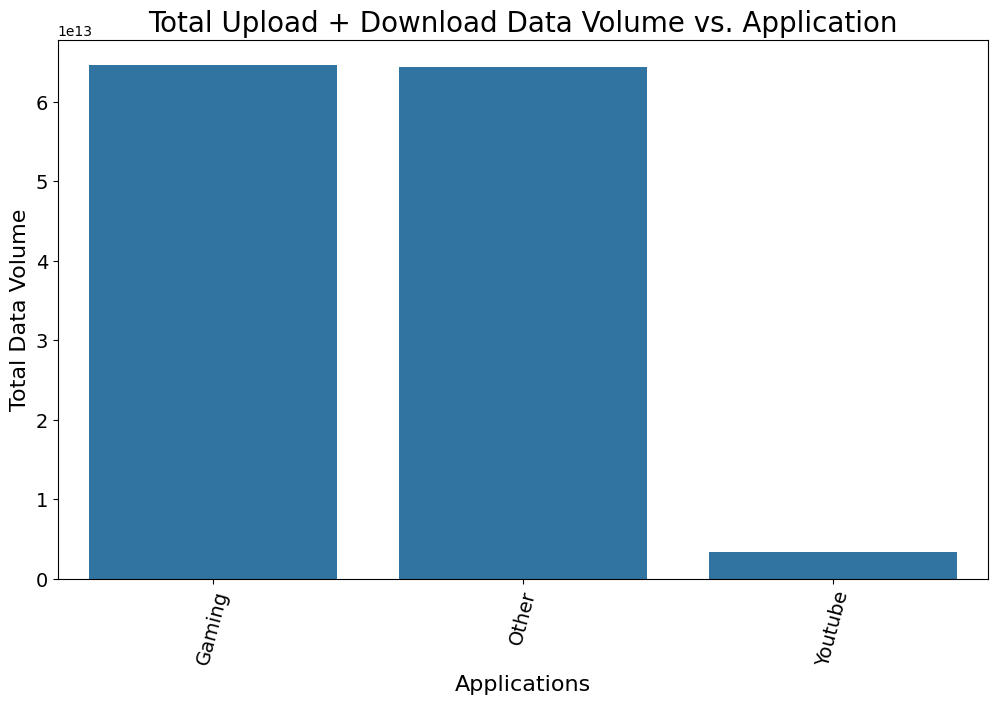

In [57]:
# List of application columns
application_columns = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Calculate total upload and download data volumes for each application
total_data = {}
for app in application_columns:
    total_data[app] = df[app + ' DL (Bytes)'].sum() + df[app + ' UL (Bytes)'].sum()

# Create a new DataFrame with the total data volumes
total_data_df = pd.DataFrame.from_dict(total_data, orient='index', columns=['Total Data Volume'])
total_data_df.index.name = 'Applications'

# Select the top 3 most used applications based on total data volume
top_3_apps = total_data_df.nlargest(3, 'Total Data Volume')

plot_bar(df=top_3_apps,
         x_col= top_3_apps.index,
         y_col='Total Data Volume',
         title='Total Upload + Download Data Volume vs. Application',
         xlabel='Applications',
         ylabel='Total Data Volume')

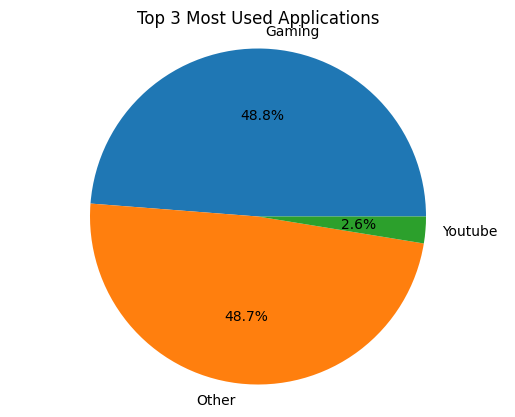

In [58]:
# Plot a pie chart for the top 3 most used applications
plt.pie(top_3_apps['Total Data Volume'], labels=top_3_apps.index, autopct='%1.1f%%')
plt.title('Top 3 Most Used Applications')
plt.axis('equal')
plt.show()

### Users in k engagement clusters 

Using k-means clustering algorithm, let's group users in k engagement clusters based on the engagement metrics. 


In [60]:
# ----- To Do ---------- #